### Calibration code for the dataset Bla bla

The calibration process applies to network setups that produce both predictions and associated uncertainty estimates. Networks are considered calibrated when the predicted uncertainties align with the actual prediction errors (e.g., RMSE). To achieve this, a transformation is applied to map uncertainty predictions to measured errors. An ideal calibration would result in a plot tightly fitting 
𝑦=𝑥, where 
𝑦 represents the error and 
𝑥 the estimated uncertainty.

Following the methodology from [1,20], we sampl 𝑘=50
predictions per input image and compute pixel-wise standard deviations 𝜎1
and 𝜎2 for the two predicted image channels 𝑐1 and 𝑐2. These serve as the uncertainty predictions. To calibrate, the uncertainties are scaled using two learnable scalars, 1 and 𝛼2. Importantly, this calibration does not alter the original predictions but learns a mapping to accurately predict the measured errors.

#### General imports

In [20]:
import os
import pooch
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lvae_training.calibration import (
    Calibration,
    plot_calibration,
)
from careamics.lvae_training.dataset import DataSplitType

### Define sub-experiment 

In [21]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

class Channels:
    Nucleus = 0
    MicroTubules = 1
    NuclearMembrane = 2
    Centromere = 3

class ExposureDuration:
    VeryLow = "2ms"
    Low = "3ms"
    Medium = "5ms"
    High = "20ms"
    VeryHigh = "500ms"

allowed_exposure_durations = [ExposureDuration.VeryLow, ExposureDuration.Low, ExposureDuration.Medium, ExposureDuration.High, ExposureDuration.VeryHigh]

## Select the channels and exposure duration
<div class="alert alert-block alert-info">
<b> Task: </b>Set two entries from the following list for the channels.
0 - Nucleus, 1 - Microtubules, 2 - Centromere, 3 - Nuclear Membrane
An example would be [0, 1] for Nucleus and Microtubules.
</div>

In [22]:
TARGET_CHANNEL_IDX_LIST = [Channels.MicroTubules, Channels.Nucleus]

<div class="alert alert-block alert-info">
<b> Task: </b>Pick one entry from the following list for the exposure duration.
VeryLow, Low,Medium,High, VeryHigh
</div>

In [23]:
EXPOSURE_DURATION = ExposureDuration.Medium


In [24]:
TARGET_CHANNEL_IDX_LIST = sorted(TARGET_CHANNEL_IDX_LIST)
assert EXPOSURE_DURATION in allowed_exposure_durations, f"Exposure duration {EXPOSURE_DURATION} not in {allowed_exposure_durations}"
assert len(TARGET_CHANNEL_IDX_LIST) == 2, f"Only 2 target channels are allowed, got {len(TARGET_CHANNEL_IDX_LIST)}"

In [25]:
from notebook_utils import get_all_channel_list
CHANNEL_IDX_LIST = get_all_channel_list(TARGET_CHANNEL_IDX_LIST)

### Download the data

In [26]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data/",
    registry={f"ht_lif24_{EXPOSURE_DURATION}.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/noise_models/{EXPOSURE_DURATION}/",
    registry={
        f"noise_model_Ch{CHANNEL_IDX_LIST[0]}.npz": None,
        f"noise_model_Ch{CHANNEL_IDX_LIST[1]}.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path=f"./pretrained_checkpoints/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/ckpts/{EXPOSURE_DURATION}/",
    registry={f"best_{TARGET_CHANNEL_IDX_LIST[0]}_{TARGET_CHANNEL_IDX_LIST[1]}.ckpt": None},
)


In [27]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname)

for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip())

pretrained_model_available = False
for f in MODEL_CHECKPOINTS.registry:
    if MODEL_CHECKPOINTS.is_available(f):
        MODEL_CHECKPOINTS.fetch(f"{f}")
        pretrained_model_available = True

assert pretrained_model_available, "Pretrained model not available. First train the model using the 01_training.ipynb."

In [28]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

### Get configs

In [29]:
train_data_config, val_data_config, test_data_config = get_data_configs(
    dset_type=EXPOSURE_DURATION, channel_idx_list=CHANNEL_IDX_LIST,
)
experiment_params = get_microsplit_parameters(
    dset_type=EXPOSURE_DURATION, nm_path=NOISE_MODELS.path, channel_idx_list=CHANNEL_IDX_LIST
)

### Create dataset

In [30]:
train_dset, _, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_lif24_{EXPOSURE_DURATION}.zip.unzip/{EXPOSURE_DURATION}",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=test_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set1/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set2/uSplit_5ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set3/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set4/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set5/uSplit_5ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set6/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: Fals

### Get experiment configs

In [31]:
experiment_params["data_stats"] = data_stats  # TODO rethink

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Load Validation-set predictions for fitting the calibration params

In [32]:
pred_dir = f"predictions/{EXPOSURE_DURATION}"
pred_fname = 'prediction_ht_lif24_Val.tif'
std_fname = 'std_ht_lif24_Val.tif'

prediction = tifffile.imread(f"{pred_dir}/{pred_fname}")
std = tifffile.imread(f"{pred_dir}/{std_fname}")



#### Target preparation

In [33]:
data_stats = experiment_params["data_stats"]
target = test_dset._data[..., :-1]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean)/ sep_std

In [34]:
# target = target[:1]
# target_normalized = target_normalized[:1]

In [35]:
calib = Calibration(
    num_bins=30,
)
native_stats = calib.compute_stats(
    pred=prediction,
    pred_std=std,
    target=target_normalized
)
count = np.array(native_stats[0]['bin_count'])
count = count / count.sum()


### Load Test-set predictions for evaluating the calibration

In [36]:
pred_dir = f"predictions/{EXPOSURE_DURATION}"
pred_fpath = os.path.join(pred_dir,'prediction_ht_lif24_Test.tif')
std_fpath = os.path.join(pred_dir,'std_ht_lif24_Test.tif')
assert os.path.exists(pred_fpath), f"Prediction file {pred_fpath} not found. Run the 02_evaluation.ipynb first on Test data."
assert os.path.exists(std_fpath), f"Std file {std_fpath} not found. Run the 02_evaluation.ipynb first on Test data."
prediction = tifffile.imread(pred_fpath)
std = tifffile.imread(std_fpath)


### Compute calibration factors


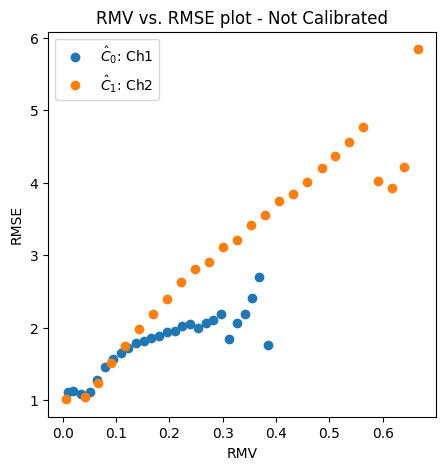

In [37]:
_,ax = plt.subplots(figsize=(5,5))
plt.title("RMV vs. RMSE plot - Not Calibrated")
plot_calibration(ax, native_stats)

### Perform calibration


In [38]:
# Compute calibration factors for the channels
calib_factors, factors_array = calib.get_calibrated_factor_for_stdev()
print(f"Calibration factors: {calib_factors}")

Calibration factors: {0: {'scalar': 3.089337924319244, 'offset': 1.1989881449427928}, 1: {'scalar': 6.008922431774148, 'offset': 1.1174203903974083}}


### Apply calibration factors

In [39]:
# Use pre-computed calibration factor
calib = Calibration(num_bins=30)

stats = calib.compute_stats(
    prediction,
    std * factors_array["scalar"] + factors_array["offset"],
    target_normalized
)

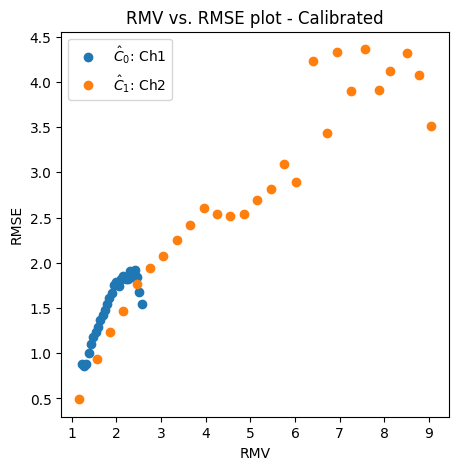

In [40]:
_,ax = plt.subplots(figsize=(5,5))
plt.title("RMV vs. RMSE plot - Calibrated")
plot_calibration(ax, stats)